# Work Sample
## Devin Cavagnaro

### Part 1: Exploratory Data Analysis

First, we will import the packages needed for this analysis.

In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score, cross_val_predict, train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn import tree
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

Creating a helper function to create confusion matrices.

In [16]:
def create_matrix(cm, title):
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative','Positive']
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))

This code reads in the data to a dataframe and prints out the first few rows. The first thing to take note of is the date column. The meta data says this will be YYYY-MM-DD format but it appears to be in a different format. For now this isn't an issue but it is something we should come back to.

In [4]:
df = pd.read_csv('../Work Sample/device_failure.csv')
df.head()

,date,device,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,failure
0,15001,S1F01085,215630672,56,0,52,6,407438,0,0,7,0
1,15001,S1F0166B,61370680,0,3,0,6,403174,0,0,0,0
2,15001,S1F01E6Y,173295968,0,0,0,12,237394,0,0,0,0
3,15001,S1F01JE0,79694024,0,0,0,6,410186,0,0,0,0
4,15001,S1F01R2B,135970480,0,0,0,15,313173,0,0,3,0


The next thing we can do is take a quick look for null values and it appears that there aren't any nulls in the data below which is a good sign. Thanks for the clean data!

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
date          124494 non-null int64
device        124494 non-null object
attribute1    124494 non-null int64
attribute2    124494 non-null int64
attribute3    124494 non-null int64
attribute4    124494 non-null int64
attribute5    124494 non-null int64
attribute6    124494 non-null int64
attribute7    124494 non-null int64
attribute8    124494 non-null int64
attribute9    124494 non-null int64
failure       124494 non-null int64
dtypes: int64(11), object(1)
memory usage: 11.4+ MB


In [6]:
df.apply(lambda x: sum(x.isnull()), axis=0)

date          0
device        0
attribute1    0
attribute2    0
attribute3    0
attribute4    0
attribute5    0
attribute6    0
attribute7    0
attribute8    0
attribute9    0
failure       0
dtype: int64

Below we are going to check the number of failures compared to the number of non-failures. It looks like about .09% of the data are failures.

In [7]:
print('# Devices that failed = {}'.format(len(df[df['failure'] == 1]))) 

print('# Devices that did not fail = {}'.format(len(df[df['failure'] == 0])))

print('% of Devices that failed = {}%'.format(round((len(df[df['failure'] == 1])) / len(df) * 100, 2)))  

# Devices that failed = 106
# Devices that did not fail = 124388
% of Devices that failed = 0.09%


The next thing, that I will want to do is look for any correlations in the data. There looks to be some interesting patterns that are starting to appear. The main thing that jumps out at me is the correlation between attribute 3 and attribute 9.

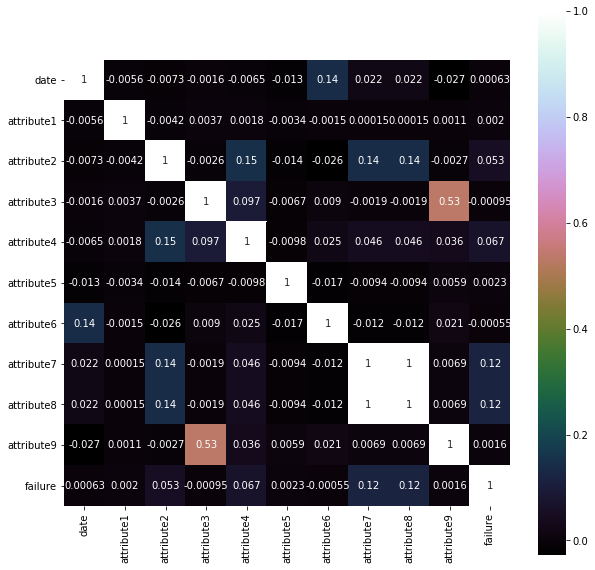

In [8]:
correlation = df.corr()  
plt.figure(figsize=(10, 10))  
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')  

The next thing I will want to look at are pairwise plots to see distributions and plots. It looks like there are some interesting groupings between attribute 4 and attribute 5 as well as between attribute 6 and attribute 3.

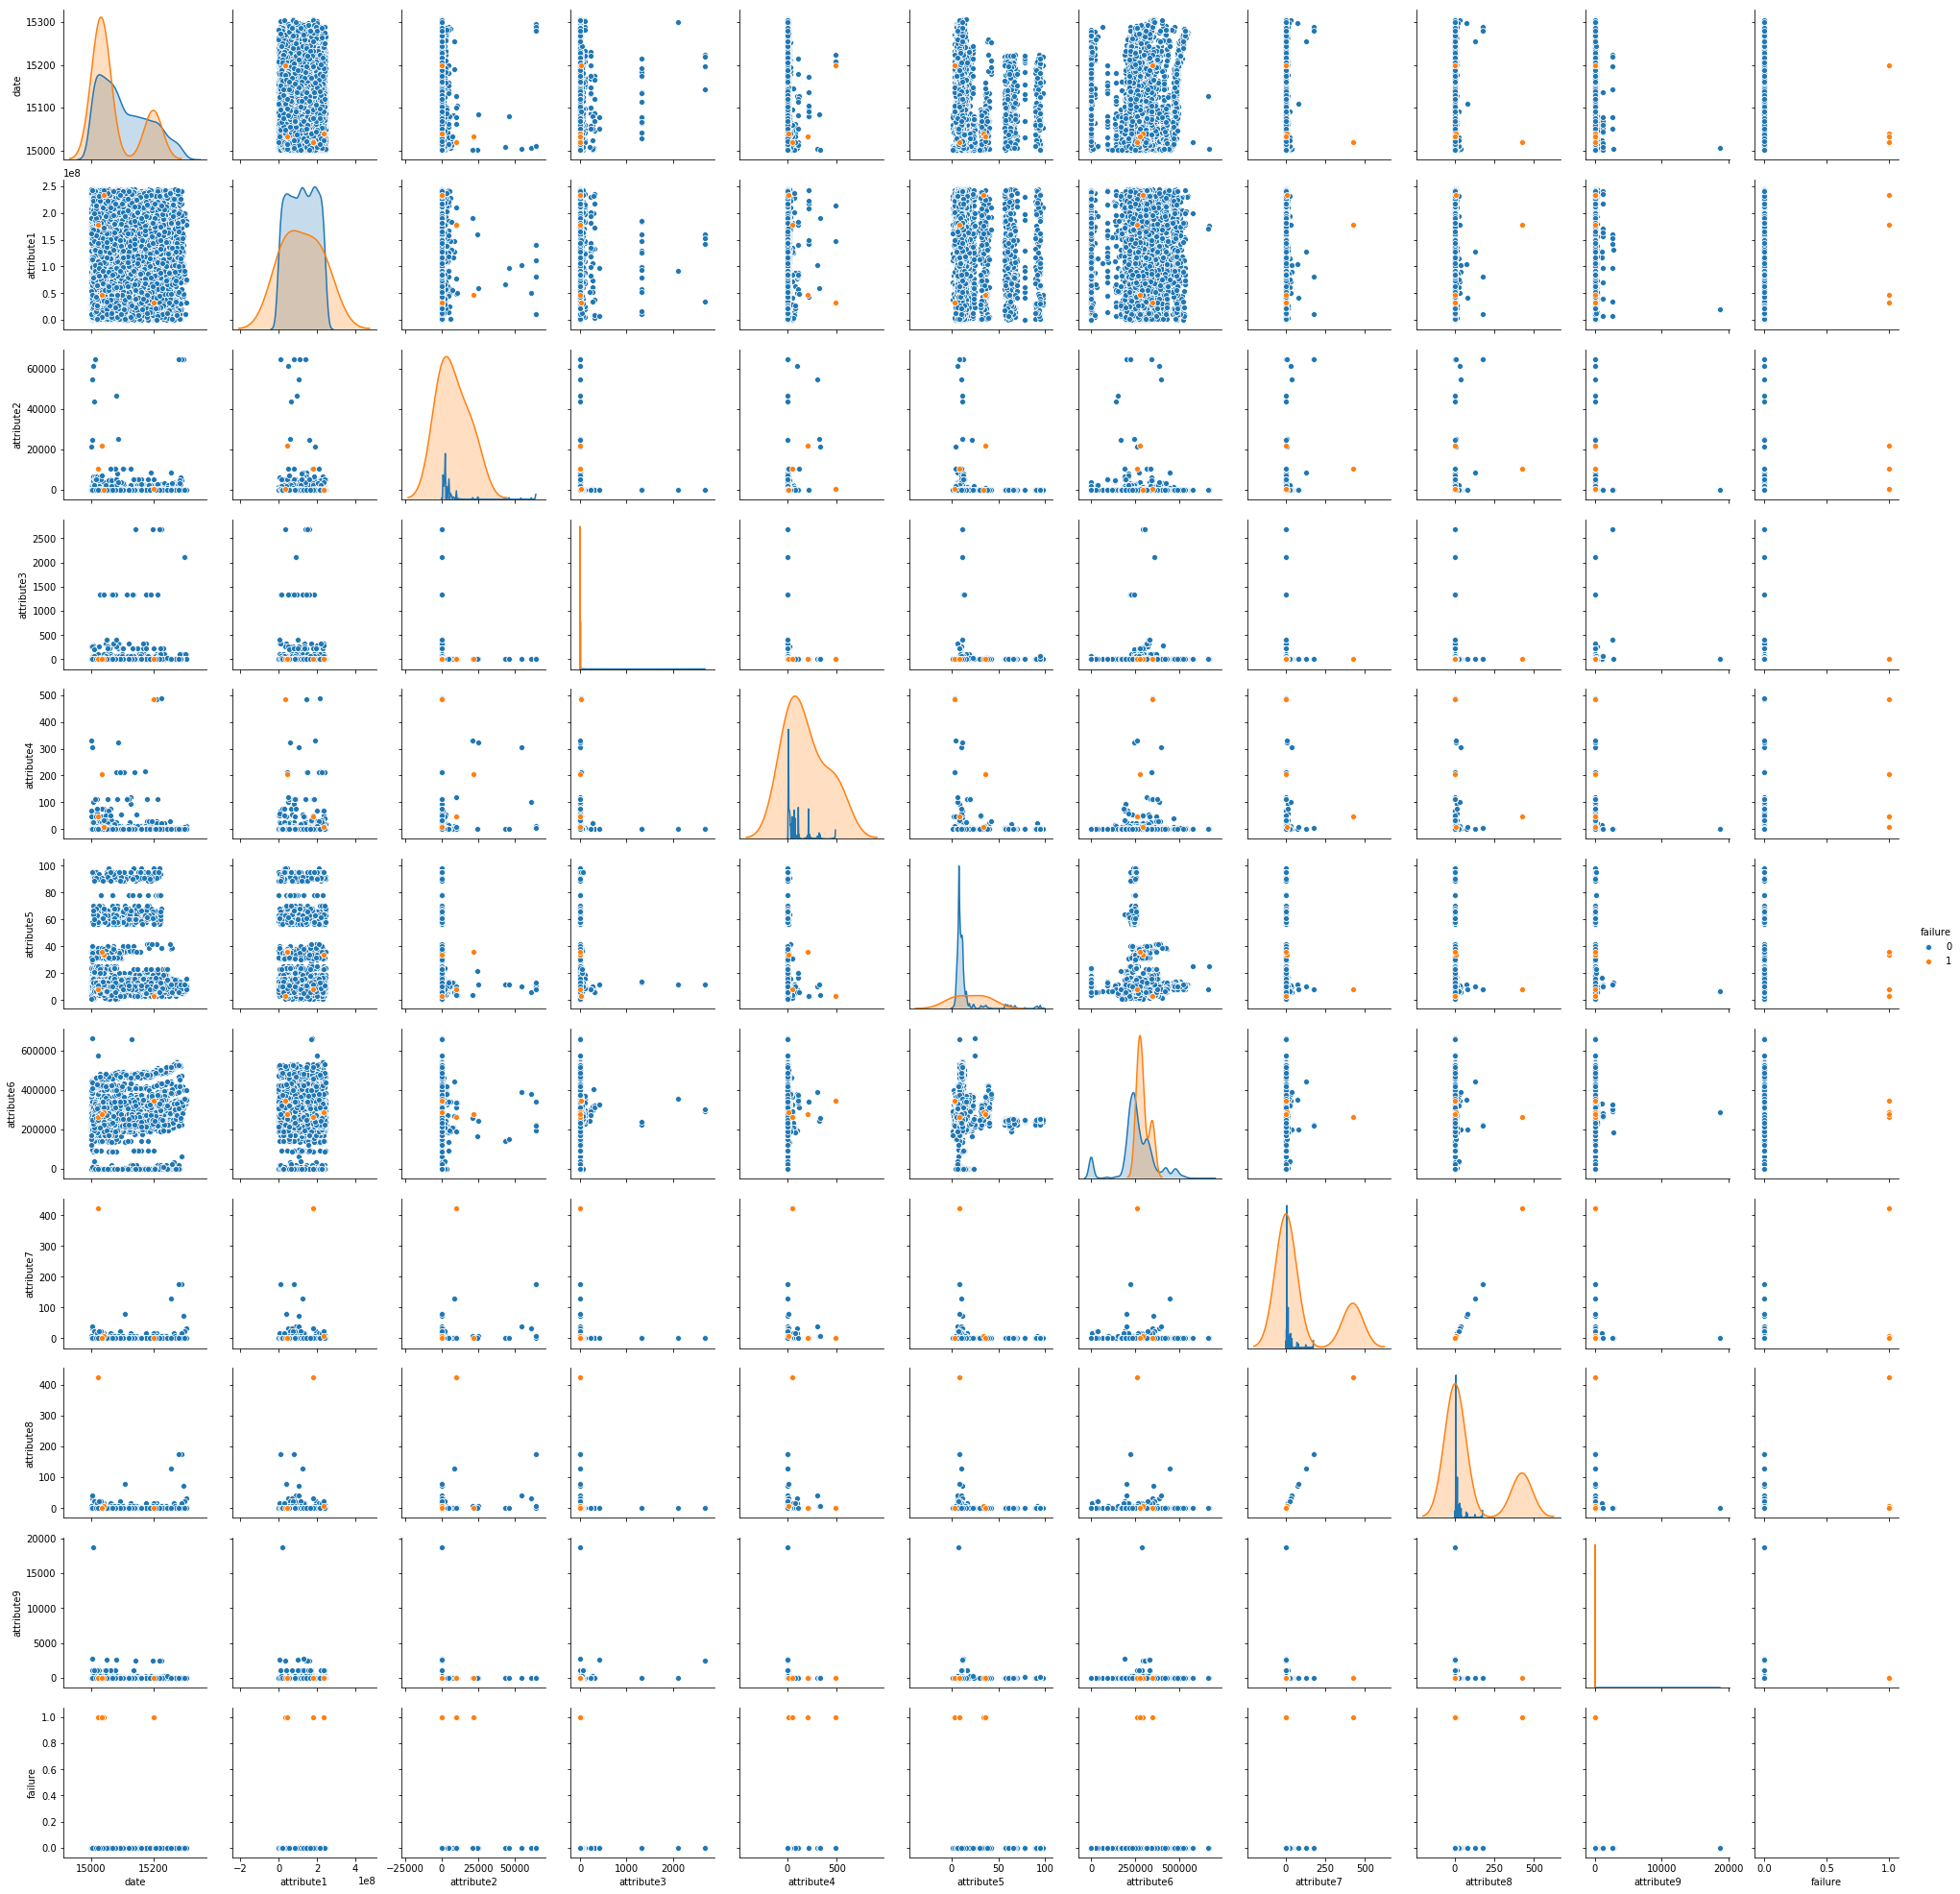

In [9]:
# take a 5% sample because of the computational power
df_sample = df.loc[:,df.columns!='device'].sample(frac=0.05)  
# Pairwise plots
pplot = sns.pairplot(df_sample, hue='failure')  

### Part 2: Building a Baseline Model

First, we will split our data into a training, validation, and testing dataset. I've decided to use a split here of 60/20/20. I have also dropped the unique ID since this won't be important to us for the purpose of modeling.

In [10]:
df = df.drop(['device'], axis =1)
train, test, validate = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])  
print(train.shape, test.shape, validate.shape) 

(74696, 11) (24899, 11) (24899, 11)


The next thing we will want to do is split out our response variable from the predictor variables for each of the sets of data.

In [11]:
y_train = train['failure']  
x_train = train.drop(['failure'], axis=1)  
y_test = test['failure']  
x_test = test.drop(['failure'], axis=1)  
y_validate = validate['failure']  
x_validate = validate.drop(['failure'], axis=1)

RandomForest has a feature importance which we can use to look at the most important features in order of their importance. It looks like attribute 1, date, and attribute 6 are the most important.

In [12]:
rf = RandomForestClassifier()  
rf.fit(x_train, y_train)  
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), x_train), reverse=True)) 

Features sorted by their score:
[(0.2388, 'attribute6'), (0.1945, 'attribute1'), (0.1839, 'date'), (0.1006, 'attribute2'), (0.0931, 'attribute4'), (0.0743, 'attribute5'), (0.0377, 'attribute7'), (0.0329, 'attribute8'), (0.0317, 'attribute9'), (0.0124, 'attribute3')]


The assignment says that we want to minimize false positives and negatives. For this problem, we are probably  most interested in knowing which devices are going to fail. That way an organisation can respond with maintenance and service to those devices.

Because this is a binary classification, we will start our modeling with a simple logistic regression model. This data has an extremely high percentage of non-failure devices which is going to cause some problems in our model. The model will be extremely biased towards non-failure devices and will predict everything as non-failures. The score below represents this problem pretty well.

In [13]:
# Instantiate
logit_model = LogisticRegression()  
# Fit
logit_model = logit_model.fit(x_train, y_train)  
# How accurate?
logit_model.score(x_train, y_train)  

# How does it perform on the test dataset?

# Predictions on the test dataset
predicted = pd.DataFrame(logit_model.predict(x_test))  
# Probabilities on the test dataset
probs = pd.DataFrame(logit_model.predict_proba(x_test))  
print(metrics.accuracy_score(y_test, predicted))

0.9989959436121932


Because there is such a large proportion of non-failures, even if we just labelled everything as a non-failure we would get this high accuracy rating which is misleading. If we look at unique predictions below, we can see that every single prediction was a 0 for non-failure. Obviously, this is not a good model.

In [14]:
# Should we be excited?
print(np.unique(predicted))

[0]


A better way to judge the accuracy of the model is a confusion matrix. We can look at a confusion matrix and see not only did we mostly classify everything as negative, we incorrectly classified 25 as negative. This is classic problem when dealing with imbalanced classes.

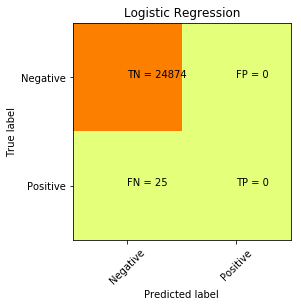

In [20]:
cm = confusion_matrix(y_test, predicted)
create_matrix(cm, 'Logistic Regression')

### Part 3: Tuning the Model

So we have created a pretty bad model, but now we have the opportunity to build a better model and implement some machine learning best practices. 

In [67]:
x = df.drop(['failure', 'date'], axis =1)
y = df['failure']

In [68]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(x,y, test_size = 0.20, random_state = 0)

#### Preprocess Data

The first thing we will do is preprocess our data. This is because our attributes contain features highly varying in magnitudes, units and range.

In [135]:
sc_x = StandardScaler()
x_train2 = sc_x.fit_transform(x_train2)
x_test2 = sc_x.transform(x_test2)

#### Upsample

The next practice that we will want to implement is upsampling our really low amount of failures. We will do this with the imblearn package. It is important to note that we want to upsample AFTER we split the dataset because some of the upsampled data can leak into the test data and cause innacurate results.

In [70]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train2==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train2==0)))

sm = SMOTE(random_state=2)
x_train_res, y_train_res = sm.fit_sample(x_train2, y_train2.ravel())

print('After OverSampling, the shape of train_X: {}'.format(x_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 84
Before OverSampling, counts of label '0': 99511 

After OverSampling, the shape of train_X: (199022, 9)
After OverSampling, the shape of train_y: (199022,) 

After OverSampling, counts of label '1': 99511
After OverSampling, counts of label '0': 99511


#### Re-Model

Lastly, we will again try to model our data.

In [25]:
# Instantiate
logit_model = LogisticRegression()  
# Fit
logit_model = logit_model.fit(x_train_res, y_train_res)  
# How accurate?
logit_model.score(x_train_res, y_train_res)  

# How does it perform on the test dataset?

# Predictions on the test dataset
predicted = pd.DataFrame(logit_model.predict(x_test2))  
# Probabilities on the test dataset
probs = pd.DataFrame(logit_model.predict_proba(x_test2))

We can again look at the cunfusion matrix to see our results.

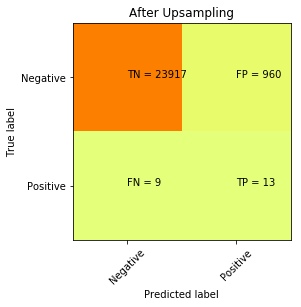

In [26]:
cm = confusion_matrix(y_test2, predicted)
create_matrix(cm, 'After Upsampling')

### Part 4: Model Selection

Using some best practices, we were able to create a better machine learning model. But maybe there is a more accurate model we could be using for this problem.

Below are the scores we will use:

Sensitivity/Recall - TP / (TP + FN) - What proportion of actual positives was identified correctly?

Specificity - TN / (TN + FP) how well the model identifies failures that will not fail.

Precision TP / (TP + FP) - What proportion of positive identifications was actually correct?

F1 score 2 * (precision * recall)/(precision + recall)is the harmonic mean betwen precision and recall or the balance.

#### Logistic Regression

In [27]:
logit_model = LogisticRegression()
logit_model = logit_model.fit(x_train_res, y_train_res)
logit_model.score(x_train_res, y_train_res)

# Store metrics
logit_accuracy = metrics.accuracy_score(y_test2, predicted)
logit_roc_auc = metrics.roc_auc_score(y_test2, probs[1])
logit_confus_matrix = metrics.confusion_matrix(y_test2, predicted)
logit_classification_report = metrics.classification_report(y_test2, predicted)
logit_precision = metrics.precision_score(y_test2, predicted, pos_label=1)
logit_recall = metrics.recall_score(y_test2, predicted, pos_label=1)
logit_f1 = metrics.f1_score(y_test2, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
logit_cv_scores = cross_val_score(LogisticRegression(), x_test2, y_test2, scoring='precision', cv=10)
logit_cv_mean = np.mean(logit_cv_scores)

#### Decision Tree

In [130]:
# Instantiate with a max depth of 3
tree_model = tree.DecisionTreeClassifier(max_depth=3)  
# Fit a decision tree
tree_model = tree_model.fit(x_train_res, y_train_res)  
# Training accuracy
tree_model.score(x_train_res, y_train_res)

# Predictions/probs on the test dataset
predicted = pd.DataFrame(tree_model.predict(x_test2))  
dt_probs = pd.DataFrame(tree_model.predict_proba(x_test2))

# Store metrics
tree_accuracy = metrics.accuracy_score(y_test2, predicted)  
tree_roc_auc = metrics.roc_auc_score(y_test2, dt_probs[1])  
tree_confus_matrix = metrics.confusion_matrix(y_test2, predicted)  
tree_classification_report = metrics.classification_report(y_test2, predicted)  
tree_precision = metrics.precision_score(y_test2, predicted, pos_label=1)  
tree_recall = metrics.recall_score(y_test2, predicted, pos_label=1)  
tree_f1 = metrics.f1_score(y_test2, predicted, pos_label=1)

# evaluate the model using 10-fold cross-validation
tree_cv_scores = cross_val_score(tree.DecisionTreeClassifier(max_depth=3), x_test2, y_test2, scoring='precision', cv=10)
tree_cv_mean = np.mean(tree_cv_scores)

#### Random Forest

In [29]:
# Instantiate
rf = RandomForestClassifier()  
# Fit
rf_model = rf.fit(x_train_res, y_train_res)  
# training accuracy
rf_model.score(x_train_res, y_train_res)

# Predictions/probs on the test dataset
predicted = pd.DataFrame(rf_model.predict(x_test2))  
probs = pd.DataFrame(rf_model.predict_proba(x_test2))

# Store metrics
rf_accuracy = metrics.accuracy_score(y_test2, predicted)  
rf_roc_auc = metrics.roc_auc_score(y_test2, probs[1])  
rf_confus_matrix = metrics.confusion_matrix(y_test2, predicted)  
rf_classification_report = metrics.classification_report(y_test2, predicted)  
rf_precision = metrics.precision_score(y_test2, predicted, pos_label=1)  
rf_recall = metrics.recall_score(y_test2, predicted, pos_label=1)  
rf_f1 = metrics.f1_score(y_test2, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
rf_cv_scores = cross_val_score(RandomForestClassifier(), x_test2, y_test2, scoring='precision', cv=10)  
rf_cv_mean = np.mean(rf_cv_scores)

#### KNN

In [30]:
# instantiate learning model (k = 3)
knn_model = KNeighborsClassifier(n_neighbors=3)  
# fit the model
knn_model.fit(x_train_res, y_train_res)  
# Accuracy
knn_model.score(x_train_res, y_train_res)

# Predictions/probs on the test dataset
predicted = pd.DataFrame(knn_model.predict(x_test2))  
probs = pd.DataFrame(knn_model.predict_proba(x_test2))

# Store metrics
knn_accuracy = metrics.accuracy_score(y_test2, predicted)  
knn_roc_auc = metrics.roc_auc_score(y_test2, probs[1])  
knn_confus_matrix = metrics.confusion_matrix(y_test2, predicted)  
knn_classification_report = metrics.classification_report(y_test2, predicted)  
knn_precision = metrics.precision_score(y_test2, predicted, pos_label=1)  
knn_recall = metrics.recall_score(y_test2, predicted, pos_label=1)  
knn_f1 = metrics.f1_score(y_test2, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
knn_cv_scores = cross_val_score(KNeighborsClassifier(n_neighbors=3), x_test2, y_test2, scoring='precision', cv=10)  
knn_cv_mean = np.mean(knn_cv_scores)  

#### Two Class Bayes

In [31]:
# Instantiate
bayes_model = GaussianNB()  
# Fit the model
bayes_model.fit(x_train_res, y_train_res)  
# Accuracy
bayes_model.score(x_train_res, y_train_res)

# Predictions/probs on the test dataset
predicted = pd.DataFrame(bayes_model.predict(x_test2))  
probs = pd.DataFrame(bayes_model.predict_proba(x_test2))

# Store metrics
bayes_accuracy = metrics.accuracy_score(y_test2, predicted)  
bayes_roc_auc = metrics.roc_auc_score(y_test2, probs[1])  
bayes_confus_matrix = metrics.confusion_matrix(y_test2, predicted)  
bayes_classification_report = metrics.classification_report(y_test2, predicted)  
bayes_precision = metrics.precision_score(y_test2, predicted, pos_label=1)  
bayes_recall = metrics.recall_score(y_test2, predicted, pos_label=1)  
bayes_f1 = metrics.f1_score(y_test2, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
bayes_cv_scores = cross_val_score(KNeighborsClassifier(n_neighbors=3), x_test2, y_test2, scoring='precision', cv=10)  
bayes_cv_mean = np.mean(bayes_cv_scores) 

#### Results

The two models that stand out the most to me are the decision tree as well as the logistic regression model. They both have pretty good scores for AUC score as well as the highest recall score.

In [137]:
# Model comparison
models = pd.DataFrame({  
  'Model': ['Logistic', 'd.Tree', 'r.f.', 'kNN',  'Bayes'],
  'Accuracy' : [logit_accuracy, tree_accuracy, rf_accuracy, knn_accuracy, bayes_accuracy],
  'Precision': [logit_precision, tree_precision, rf_precision, knn_precision, bayes_precision],
  'recall' : [logit_recall, tree_recall, rf_recall, knn_recall, bayes_recall],
  'F1' : [logit_f1, tree_f1, rf_f1, knn_f1, bayes_f1],
  'cv_precision' : [logit_cv_mean, tree_cv_mean, rf_cv_mean, knn_cv_mean, bayes_cv_mean],
  'Area Under ROC' : [logit_roc_auc, tree_roc_auc, rf_roc_auc, knn_roc_auc, bayes_roc_auc]
})
# Print table 
cols =['Model', 'Accuracy', 'F1', 'Precision', 'cv_precision', 'recall', 'Area Under ROC']
models[cols]

,Model,Accuracy,F1,Precision,cv_precision,recall,Area Under ROC
0,Logistic,0.961083,0.026131,0.013361,0.0,0.590909,0.804158
1,d.Tree,0.924656,0.015740,0.007962,0.0,0.681818,0.856361
2,r.f.,0.998554,0.217391,0.208333,0.0,0.227273,0.766993
3,kNN,0.991887,0.081818,0.045455,0.0,0.409091,0.722569
4,Bayes,0.986305,0.060606,0.032258,0.0,0.500000,0.790073


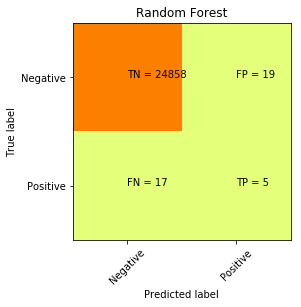

In [33]:
create_matrix(rf_confus_matrix, 'Random Forest')

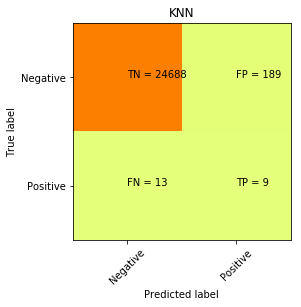

In [34]:
create_matrix(knn_confus_matrix, 'KNN')

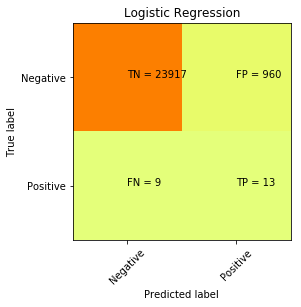

In [35]:
create_matrix(logit_confus_matrix, 'Logistic Regression')

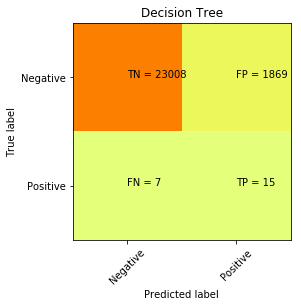

In [36]:
create_matrix(tree_confus_matrix, 'Decision Tree')

### Part 5: Tune Parameters

#### Logistic Regression

I'm chosing to tune the parameters for the logistic regression model. I liked this model the best for its predictions. It had the second highest prediction rates without too many false positives.

In [38]:
logistic = LogisticRegression()

# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

I'm using GridSearchCV on the parameters above to run the model with all of the parameters listed. GridSearch will choose the best model for the problem.

In [39]:
# Create grid search using 5-fold cross validation
clf = GridSearchCV(logistic, hyperparameters, cv=5, verbose=0)

In [40]:
best_model = clf.fit(x_train_res, y_train_res)

The best parameters determined for the logistic model are printed below.

In [41]:
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l1
Best C: 10000.0


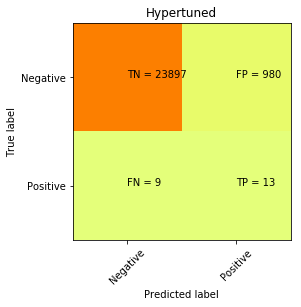

In [42]:
predicted = pd.DataFrame(best_model.predict(x_test2))
cm = confusion_matrix(y_test2, predicted)
create_matrix(cm, 'Hypertuned')

So it looks like using gridsearch did not creeate a better model. In fact it increased false positives. The last thing we are going to do is adjust the cut-off and see how that affects the confusion matrix.

### Part 6: Setting an Optimal Cut-off

I chose to use the two highest performing algorithms, Logistics and Decision Tree. The decision tree actually does a better job of predicting true positives while at the same time not creating false positives.

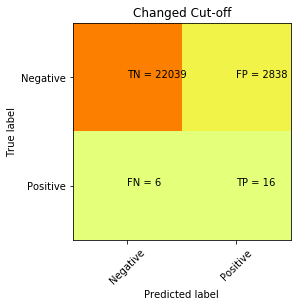

In [143]:
probs = pd.DataFrame(best_model.predict_proba(x_test2)[:,1])
predicted = [1 if i > 0.39 else 0 for i in probs[0]]
cm = confusion_matrix(y_test2, predicted)
create_matrix(cm, 'Changed Cut-off')

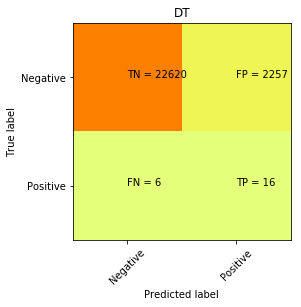

In [129]:
dt_predicted = [1 if i > 0.248202 else 0 for i in dt_probs[1]]
dt_cm = confusion_matrix(y_test2, dt_predicted)
create_matrix(dt_cm, 'DT')

### Conclusion

In [133]:
models = pd.DataFrame({  
  'Metric': ['Accuracy', 'ROC AUC', 'Precision',  'Recall', 'f1'],
  'Result' : [tree_accuracy, tree_roc_auc, tree_precision, tree_recall, tree_f1]
}) 

In [144]:
print("Results of Decision Tree Model")
models

Results of Decision Tree Model


,Accuracy,Area Under ROC,F1,Model,Precision,cv_precision,recall
0,0.961083,0.804158,0.026131,Logistic,0.013361,0.0,0.590909
1,0.924656,0.856361,0.015740,d.Tree,0.007962,0.0,0.681818
2,0.998554,0.766993,0.217391,r.f.,0.208333,0.0,0.227273
3,0.991887,0.722569,0.081818,kNN,0.045455,0.0,0.409091
4,0.986305,0.790073,0.060606,Bayes,0.032258,0.0,0.500000


With the decision tree model, I could minimize false positives and false negatives. I wanted to minimize false negatives as much as possible with the assumption that if these were AWS servers, this could potentially lead to lots of down time and result in the loss of business and money. The two models that had the most success were the logistic regression model as well as the decision tree model. I ended up choosing the decision tree model because it had half as many false positives as the logistic model. This decision tree also had an Area Under and ROC curve score of .85 which is a "good" score for a classifier like this. 

I think given a week getting a "good" classifier is a pretty good starting point on this problem. Given more time, there are a few other things that I would've liked to explore. I would've wanted to spend more time doing feature generation as well as handling outliers. For this exercise, I left all the outliers in the data because I didn't know what the actual data represented. This would have been important in determining how to handle outliers.

I wanted to show my experience of knowledge using the standard machine learning algorithms, so I didn't explore any xgboost or deep learning algorithms. Again, given more time, I would have liked to explore more cutting-edge models to see how they handled this problem.

In [146]:
import nbconvert